In [1]:
using Plots, Plots.PlotMeasures, LaTeXStrings, JLD2, FileIO, CPUTime, TickTock, LinearAlgebra, SpecialFunctions, NLsolve, ForwardDiff, DataStructures, Statistics, Distributions, LsqFit

# **Define All the Functions** 

## **The function to search an element closest to a real number in ana array**

In [2]:
function find_closest(A::AbstractArray{T}, b::T) where {T<:Real}
    if length(A) <= 1
        return firstindex(A)
    end

    i = searchsortedfirst(A, b)

    if i == firstindex(A)
        return i
    elseif i > lastindex(A)
        return lastindex(A)
    else
        prev_dist = b - A[i-1]
        next_dist = A[i] - b

        if prev_dist < next_dist
            return i - 1
        else
            return i
        end
    end
end

find_closest (generic function with 1 method)

## **Define the equilibrium fermi function**

In [3]:
@inline function f0( E, T0 )
    
    f0 = 1.0 / ( exp(E/T0) + 1.0 );
    
    return f0 
    
end    

f0 (generic function with 1 method)

## **Define the equilibrium bose function**

In [4]:
@inline function b0( E, T0 )
    
    b0 = 1.0 / ( exp(E/T0) - 1.0 );
    
    return b0 
    
end    

b0 (generic function with 1 method)

## **Define the partial derivative of the equilibrium fermi function**

In [5]:
@inline function d_E_f0( E, T0 )

    d_E_f0 = (1/T0) * f0( E, T0 ) * ( f0( E, T0 ) - 1 );
    
    return d_E_f0 
    
end 

d_E_f0 (generic function with 1 method)

## **Define the $Z_0$ function appearing in the diagonals of the $A$ matrix**

In [6]:
@inline function Z0( E, N_Phonon, Ω_List, λ_List, T0 )

    Z0 = 1.0

    for i = 1:N_Phonon 
    
        Z0 = Z0 - ( ( λ_List[i] * (Ω_List[i])^2 )/(4*pi*(Ω_List[i])*T0) ) * imag( polygamma( 1, (1/2) + im*( (E+Ω_List[i])/(2.0*pi*T0) ) ) - polygamma( 1, (1/2) + im*( (E-Ω_List[i])/(2.0*pi*T0) ) ) );

    end
    
    return Z0 
    
end 

Z0 (generic function with 1 method)

## **Define the function appearing in the diagonals of the $A$ matrix**

In [7]:
@inline function a( E, N_Phonon, Ω_List, λ_List, T0 )

    a  = Z0( E, N_Phonon, Ω_List, λ_List, T0 ) * d_E_f0( E, T0 );
    
    return a 
    
end 

a (generic function with 1 method)

## **Define the function to fill in the elements of the $A$ matrix**

In [8]:
@inline function Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 )

    for j = 1 : L
        
        for k = 1 : L
            Ej = j*ΔE;

            if k == j                    
                A_Total_Mat[j,k] = a( Ej, N_Phonon, Ω_List, λ_List, T0 );
            end 

        end            
    end 
    
end      

Fill_A_Total! (generic function with 1 method)

## **Define the function to fill in the elements of the $B$ matrix**

In [9]:
@inline function Fill_B!( B_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if     k == j - r                    
                B_Mat[j,k] = 0;

            elseif k == j + r
                B_Mat[j,k] = 0;

            elseif k == r - j
                B_Mat[j,k] = 0;

            else                    
                B_Mat[j,k] = (λ*Ω^2) * ( d_E_f0( Ej, T0 ) * d_E_f0( Ek, T0 ) * 4.0 * j * k * ΔE ) / ( ( (j-k)^2 - r^2 ) * ( (j+k)^2 - r^2 ) );

            end 

        end            
    end
     
end      

Fill_B! (generic function with 1 method)

## **Define the prefactor $\alpha(\Omega, T_0) = \pi \left( \frac{\lambda \Omega}{T_0} \right) n_{B}(\Omega)(n_{B}(\Omega)+1)$ that appears in the $C$ and the $D$ matrices**

In [10]:
@inline function α( λ, Ω, T0 )
    
    α = ( (pi*λ*Ω)/T0 ) * b0( Ω, T0 ) * ( b0( Ω, T0 ) + 1);
    
    return α 
    
end 

α (generic function with 1 method)

## **Define the function to fill in the elements of the $C$ matrix**

In [11]:
@inline function Fill_C!( C_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L

            if k == j 

                C_Mat[j,k] = α( λ, Ω, T0 ) * ( f0( (Ej-Ω), T0 ) - f0( (Ej+Ω), T0 ) );

            end 

        end            
    end 
    
end      

Fill_C! (generic function with 1 method)

## **Define the function to fill in the elements of the $P$ and the $Q$ matrices. The $D$ matrix is defined as $D = P + P^\textrm{T} - Q$.**

### **Define the function to fill in the elements of the $P$ matrix.**

In [12]:
@inline function Fill_P!( P_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if     k == j + r    

                P_Mat[j,k] = α( λ, Ω, T0 ) * ( f0( Ej, T0 ) - f0( Ek, T0 ) );

            end 

        end            
    end
     
end      

Fill_P! (generic function with 1 method)

### **Define the function to fill in the elements of the $Q$ matrix.**

In [13]:
@inline function Fill_Q!( Q_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if   k == r - j

                Q_Mat[j,k] = α( λ, Ω, T0 ) * ( 1 - f0( Ej, T0 ) - f0( Ek, T0 ) ); 

            end 

        end            
    end
     
end      

Fill_Q! (generic function with 1 method)

# **Analyze the maximum eigenvalues across criticality. This code obtains Fig. 2 in the main text.**

### The generalized eigenvalue problem in Julia is defined as: $\mathbb{A}\cdot\mathbf{x} = \sigma \mathbb{B}\cdot\mathbf{x}$, where $\mathbb{A}$ and $\mathbb{B}$ are two *real symmetric* matrices. Here $\mathbb{B}$ must be positive definite. Here $\sigma$ and $\mathbf{x}$ are *generalized eigenvalues* and *generalized eigenvectors* respectively. The command to find the generalized eigenvalues is: eigen(A, B).     

### We recast generalized eigenvalue problem (Eq. (13) in the main text) as $\underbrace{(\mathtt{A_{Total-Mat}}-\mathtt{B_{Total-Mat}})}_{A \textrm{ in Eq. (13)}} \cdot \mathbf{\dot{\varphi}} = \underbrace{(\mathtt{C_{Total-Mat}}-\mathtt{D_{Total-Mat}})}_{-M \textrm{ in Eq. (13)}} \cdot \mathbf{\varphi}$.  Writing $\mathbf{\dot{\varphi}} \propto e^{\sigma t}$, we obtain $(\mathtt{A_{Total-Mat}}-\mathtt{B_{Total-Mat}}) \cdot \mathbf{\varphi} = (1/\sigma)(\mathtt{C_{Total-Mat}}-\mathtt{D_{Total-Mat}}) \cdot \mathbf{\varphi}$. We write the generalized eigenvalue problem in this way because $(\mathtt{C_{Total-Mat}}-\mathtt{D_{Total-Mat}})$ is positive definite. As a result, the generalized eigenvalues $\sigma$ obtained in this code is related to $\gamma$ in Fig. 2 of the main text as $\sigma = -\gamma$.

### In this code, the energy $E$ is discretized in steps of $\epsilon \equiv \Delta E = 0.05$. The phonon frequencies are $\omega_{k} = (39+k)\epsilon$ with $\lambda_{k} = \lambda/21$, where $k = 1, 2, \ldots, 21$. We start at $\lambda = 0.9788$ and scan upto $\lambda = 1.9788$ in steps of $\Delta\lambda = 10^{-2}$.

In [16]:
######################################################################################################################
                    ### Define the Parameters. We choose to do it for different L manually. ### 
######################################################################################################################

L                           = 1000;                           # Related to the cut-off of the energy 

r_Left                      = 40;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency  
N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple frequencies

ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
Ω_List                      = ΔE .* r_List;                   # Ω_List
 
######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### Scanning over λ ### 
######################################################################################################################

λ_Critical           = 1.4788;                                   # The critical λ for for the 

Δλ                   = 1e-2;                                     # Choose an initial Ω step

λ_Min                = λ_Critical - 50*Δλ;                      # Choose the minimum λ

λ_Max                = λ_Critical + 50*Δλ;                      # This is the maximum value of the electron-phonon interaction that we consider

Λ_Scan_List          = range(start=λ_Min, step=Δλ, stop=λ_Max ); # Now build the λ_List

Eigs_Real_Mat        = zeros(Float64, length(Λ_Scan_List), L);   # Matrix that saves all the eigenvalues in unit of g. 
                                                                 # [Eigs_Real_Mat]_{ij} = Eigs_Real_j(λ_{i}). 
                                                                 # Number of rows = number of λ values that we consider = length(Λ_Scan_List). 
                                                                 # Number of columns = Number of eigenvalues = L.

Scaled_Eigs_Max_List = Float64[];                                # Empty list for storing the maximum eigenvalues corresponding to the specific electron-phonon interaction strengths

T0_over_g            = 0.20;

######################################################################################################################    
######################################################################################################################
######################################################################################################################


tick()

for j = 1:length(Λ_Scan_List) 



        ######################################################################################################################
                                                ### Defining the temperature. It depends on λ. ###
                                                ### This needs to be updated every time we update λ. ### 
                                                        ### All the matrices depend on T0. ###  
        ######################################################################################################################

        λ      = Λ_Scan_List[j];                              # Initialize the value of λ 

        λ_List = (λ/N_Phonon) .* ones(N_Phonon);              # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ)

        g      = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );     # g is now changed

        T0     = 0.20 * g;                                    # This should be higher than T_Critical for the kinetic equation to be valid

        ######################################################################################################################    
        ######################################################################################################################
        ######################################################################################################################
        
        
        
        ##################################################################################################################################################################
        ### DEFINING ALL THE MATRICES ###
        ##################################################################################################################################################################

        A_Total_Mat = zeros( L, L ); 
        Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );


        ######################################################################################################################
        ### Define the total B ###
        ######################################################################################################################

        B_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                B_Int_Mat   = zeros( L, L ); 
                Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                B_Total_Mat = B_Total_Mat + B_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total C ###
        ######################################################################################################################

        C_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                C_Int_Mat   = zeros( L, L ); 
                Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                C_Total_Mat = C_Total_Mat + C_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total P ###
        ######################################################################################################################

        P_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                P_Int_Mat   = zeros( L, L ); 
                Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                P_Total_Mat = P_Total_Mat + P_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total Q ###
        ######################################################################################################################

        Q_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                Q_Int_Mat   = zeros( L, L ); 
                Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;

        end

        Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 


        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



                
        ##################################################################################################################################################################
        ### Generalized eigenvalue problem: Ax = λBx. 
        ### To find λ: eigen(A, B)   
        ### The form of our problem: (C-D)φ = λ(A-B)φ
        ### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
        ### We now do the generaized diagonalization by hand.
        ### Note that: We write C-D = L.L^{T} = R^{T}.R
        ##################################################################################################################################################################

        RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
        R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;

        Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );

        F                  = eigen( Symm_LHS );

        Eigs_Real          = sort( 1.0 ./ real( F.values ) );
        Eigs_Max           = maximum( real( Eigs_Real ) ); # Obtaining the eigenvalue. We use the LinearAlgebra package.

        println("The maximum eigenvalue at T0 = $( T0/g ) at ∑ᵢλᵢ = $( λ ) is $( Eigs_Max/g ).");
        println("Energy and temperatures are given in the units of g = $( g )");
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



        ##################################################################################################################################################################
        ### SAVING THE MAXIMUM EIGENVALUES FOR THE CORRESPONDING EL-PH INTERACTIONS ###
        ### SAVING ALL THE EIGENVALUES FOR THE CORRESPONDING EL-PH INTERACTIONS ###
        ##################################################################################################################################################################

        push!( Scaled_Eigs_Max_List, (Eigs_Max/g) ); # Saving the maximum eigenvalue

        Eigs_Real_Mat[j,:] = real( Eigs_Real ) ./ g; # Saving all the eigenvalues for a specific λ as a new row

        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



end

tock()

┌ Info:  started timer at: 2025-07-08T19:15:13.986
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9787999999999999 is -0.0227490294726184.
Energy and temperatures are given in the units of g = 2.491429977609913
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9887999999999999 is -0.023233841831169142.
Energy and temperatures are given in the units of g = 2.504124597539028
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9987999999999999 is -0.02372090828358072.
Energy and temperatures are given in the units of g = 2.5167551860812103
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 1.0088 is -0.024210161882399443.
Energy and temperatures are given in the units of g = 2.5293227024903984
The maximum eigenvalue at T0 = 0.19999999999999998 at ∑ᵢλᵢ = 1.0188 is -0.024701537489253453.
Energy and temperatures are given in the units of g = 2.5418280823061186
The maximum eigenvalue at T0 = 0.20000000000000004 at ∑ᵢλᵢ = 1.0288 is -0.025194971732805348.
Energy and temperatures are given in the units of g = 2.554272238166219
The maximum eigenvalue at T0 = 0

┌ Info:         78.439464625s: 1 minute, 18 seconds, 439 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


In [18]:
@save "Data_Fig_2_Main_Text/eigenvalues_$(L)_rM_$(r_Left)_rP_$(r_Right)_T0_$(T0_over_g)_Del_E_$(ΔE)"*".jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List Eigs_Real_Mat Scaled_Eigs_Max_List;

## **Plotting the generalized eigenvalues vs $\lambda$**

### **Normal plot**

In [20]:
@load "Data_Fig_2_Main_Text/eigenvalues_1000_rM_40_rP_60_T0_0.2_Del_E_0.05.jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List Eigs_Real_Mat Scaled_Eigs_Max_List;

function SaveEigenSpectrum( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, Eigs_Real_Mat, Scaled_Eigs_Max_List ) 

    scatter( 
        Λ_Scan_List, - Eigs_Real_Mat[:,1] ./ (1e3*pi),
        shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
        tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
        guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
        framestyle = :box, grid = false, legend=:false, dpi=400,
        topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    for i = 2:1:L

        scatter!( 
            Λ_Scan_List, - Eigs_Real_Mat[:,i] ./ (1e3*pi),
            shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
            tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
            framestyle = :box, grid = false, legend=:false, dpi=400,
            topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    end

    plot!([1.4788], seriestype="vline", dpi=400,
          lw=2, linestyle=:dash, linecolor=:red )

    xlims!( 1.0,  1.6 )
    ylims!( -1e0, 1e0 )

    Xt = collect(range(1.1,  1.6, step=0.2));
    Yt = collect(range( -1e0, 1e0, step=0.5));

    xticks!(Xt, string.( round.( Xt, digits=1 ) ))
    yticks!(Yt, string.( round.( Yt, digits=2 ) ))

    savefig("Data_Fig_2_Main_Text/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis.png")

end

SaveEigenSpectrum( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, Eigs_Real_Mat, Scaled_Eigs_Max_List )

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Metallic_Instability_El-Ph_Interaction/Data_Fig_2_Main_Text/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis.png"

### **Magnified plot**

In [22]:
@load "Data_Fig_2_Main_Text/eigenvalues_1000_rM_40_rP_60_T0_0.2_Del_E_0.05.jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List Eigs_Real_Mat Scaled_Eigs_Max_List;

function SaveEigenSpectrum_Mag( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, Eigs_Real_Mat, Scaled_Eigs_Max_List ) 

    scatter( 
        Λ_Scan_List, - Eigs_Real_Mat[:,1] ./ pi,
        shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
        tickfont=font(25,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
        guidefont = font(30,"Computer Modern"), legendfont=(11,"Computer Modern"),
        framestyle = :box, grid = false, legend=:false, dpi = 400,
        topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    for i = 2:1:L

        scatter!( 
            Λ_Scan_List, - Eigs_Real_Mat[:,i] ./ pi,
            shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
            tickfont=font(25,"Computer Modern"), titlefont = font(30,"Computer Modern"), 
            framestyle = :box, grid = false, legend=:false, dpi = 400,
            topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    end

    
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################



    plot!([1.4788], seriestype="vline", dpi = 400,
          lw=2, linestyle=:dash, linecolor=:red )

    plot!([0], seriestype="hline", dpi = 400,
          lw=2, linestyle=:solid, linecolor=:green )

    xlims!( 1.0,  1.6 )
    ylims!( -0.05, 0.05 )

    Xt = collect(range(1.1,  1.6, step=0.2));
    Yt = collect(range( -0.05, 0.05, step=0.05));

    xticks!(Xt, string.( round.( Xt, digits=1 ) ))
    yticks!(Yt, string.( round.( Yt, digits=3 ) ))

    savefig("Data_Fig_2_Main_Text/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis_Mag.png")

end

SaveEigenSpectrum_Mag( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, Eigs_Real_Mat, Scaled_Eigs_Max_List )

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Metallic_Instability_El-Ph_Interaction/Data_Fig_2_Main_Text/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis_Mag.png"

# **Plot of generailzed eigenvectors for $\lambda = 5.0$.** 

### In this code, the energy $E$ is discretized in steps of $\epsilon \equiv \Delta E = 0.05$. The phonon frequencies are $\omega_{k} = (39+k)\epsilon$ with $\lambda_{k} = \lambda/21$, where $k = 1, 2, \ldots, 21$.

In [23]:
L                           = 1000;                           # Related to the cut-off of the energy 

r_Left                      = 40;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency 

N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
# N_Phonon                    = Int( 7 - 3 + 1 );             # Number of phonons

r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple phonon frequencies
# r_List                      = r_Right .* ones(N_Phonon);    # Considering multiple phonons with the same frequency

ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
Ω_List                      = ΔE .* r_List;                   # Ω_List

λ                           = 5.0000;                         # Change the overall scale of λᵢ indepenent of Ωᵢ. Remember that λCritical = 2.5438 for T0 = 0.2g with r = 10,…,60. 
λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ (λᵢΩᵢ/2) δ(Ω - Ωᵢ) 

g                           = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );
T0                          = 0.20 * g;  # This should be higher than T_Critical for the kinetic equation to be valid 

println("g = $( g ).");
println("Energy cut-off in units of g = $( ΔE*L/g ) Done!");

g = 5.631015302175385.
Energy cut-off in units of g = 8.87939338056565 Done!


## **Calculating generalized eigenvalues**

In [24]:
##################################################################################################################################################################
### DEFINING ALL THE MATRICES ###
##################################################################################################################################################################

A_Total_Mat = zeros( L, L ); 
Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );


######################################################################################################################
### Define the total B ###
######################################################################################################################

B_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    B_Int_Mat   = zeros( L, L ); 
    Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    B_Total_Mat = B_Total_Mat + B_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total C ###
######################################################################################################################

C_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    C_Int_Mat   = zeros( L, L ); 
    Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    C_Total_Mat = C_Total_Mat + C_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total P ###
######################################################################################################################

P_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    P_Int_Mat   = zeros( L, L ); 
    Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    P_Total_Mat = P_Total_Mat + P_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total Q ###
######################################################################################################################

Q_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    Q_Int_Mat   = zeros( L, L ); 
    Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;

end

Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.

######################################################################################################################
######################################################################################################################
######################################################################################################################


D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 


##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################



##################################################################################################################################################################
### Generalized eigenvalue problem: Ax = λBx. 
### To find λ: eigen(A, B)   
### The form of our problem: (C-D)φ = λ(A-B)φ
### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
### We now do the generaized diagonalization by hand.
### Note that: We write C-D = L.L^{T} = R^{T}.R
### This does not work well for the no self energy case, since Cholesky decomposition makes O(10^-18) error. 
### There are matrix elements O(10^-32) in the original matrix
##################################################################################################################################################################

##########################################################################################################################

RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;

Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );

F                  = eigen( Symm_LHS );

Eigs_Real          = sort( 1.0 ./ real( F.values ) );

##########################################################################################################################

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################



##########################################################################################################################
### Scanning the full spectrum
##########################################################################################################################

Eigs_Real_Positive = Eigs_Real[ Eigs_Real .> 0 ];      # Selects elements in Eigs_Real that are greater than zero 
Eigs_Real_Negative = Eigs_Real[ Eigs_Real .< 0 ];      # Selects elements in Eigs_Real that are less than zero

println("The number of positive generalized eigenvalues is = $( length(Eigs_Real_Positive) )");
println("The number of negative generalized eigenvalues is = $( length(Eigs_Real_Negative) )");

num_eigs           = 5;

EigsJ_n_max        = nlargest(  num_eigs, Eigs_Real );

EigsJ_n_min        = nsmallest( num_eigs, Eigs_Real );

λJmax              = maximum( real( Eigs_Real ) );     # Obtaining the eigenvalue. We use the LinearAlgebra package.

##########################################################################################################################
##########################################################################################################################
##########################################################################################################################



println("The $( num_eigs ) largest eigenvalues are $( EigsJ_n_max ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

println("The $( num_eigs ) smallest eigenvalues are $( EigsJ_n_min ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

println("The maximum eigenvalue is $( λJmax ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

EigsJ_n_Positive_min = nsmallest( num_eigs, Eigs_Real_Positive );
EigsJ_n_Negative_max = nlargest(  num_eigs, Eigs_Real_Negative  );

# EigsJ_n_Positive_min = vcat( EigsJ_n_Positive_min, zeros(num_eigs - length(EigsJ_n_Positive_min)) );

println("The $( num_eigs ) smallest postive eigenvalues at average Ω = $( round( sqrt(mean(Ω_List.^2)); digits=3 ) ) and λ = $( round( sum(λ_List); digits=3) ) are $( EigsJ_n_Positive_min ). Done!");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("The $( num_eigs ) largest negative eigenvalues at average Ω = $( round( sqrt(mean(Ω_List.^2)); digits=3 ) ) and λ = $( round( sum(λ_List); digits=3) ) are $( EigsJ_n_Negative_max ). Done!");



##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################

The number of positive generalized eigenvalues is = 62
The number of negative generalized eigenvalues is = 938
The 5 largest eigenvalues are [4443.231500229109, 1831.3722902454904, 1168.545435850899, 1134.897405394735, 833.1731238489638]. Done!
-----------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------
The 5 smallest eigenvalues are [-10831.18612619864, -2464.342198370167, -2022.7289124362778, -1398.222341888456, -979.9672405358364]. Done!
-----------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------

## **Plotting the eigenvector**

### **Stable eigenvectors**

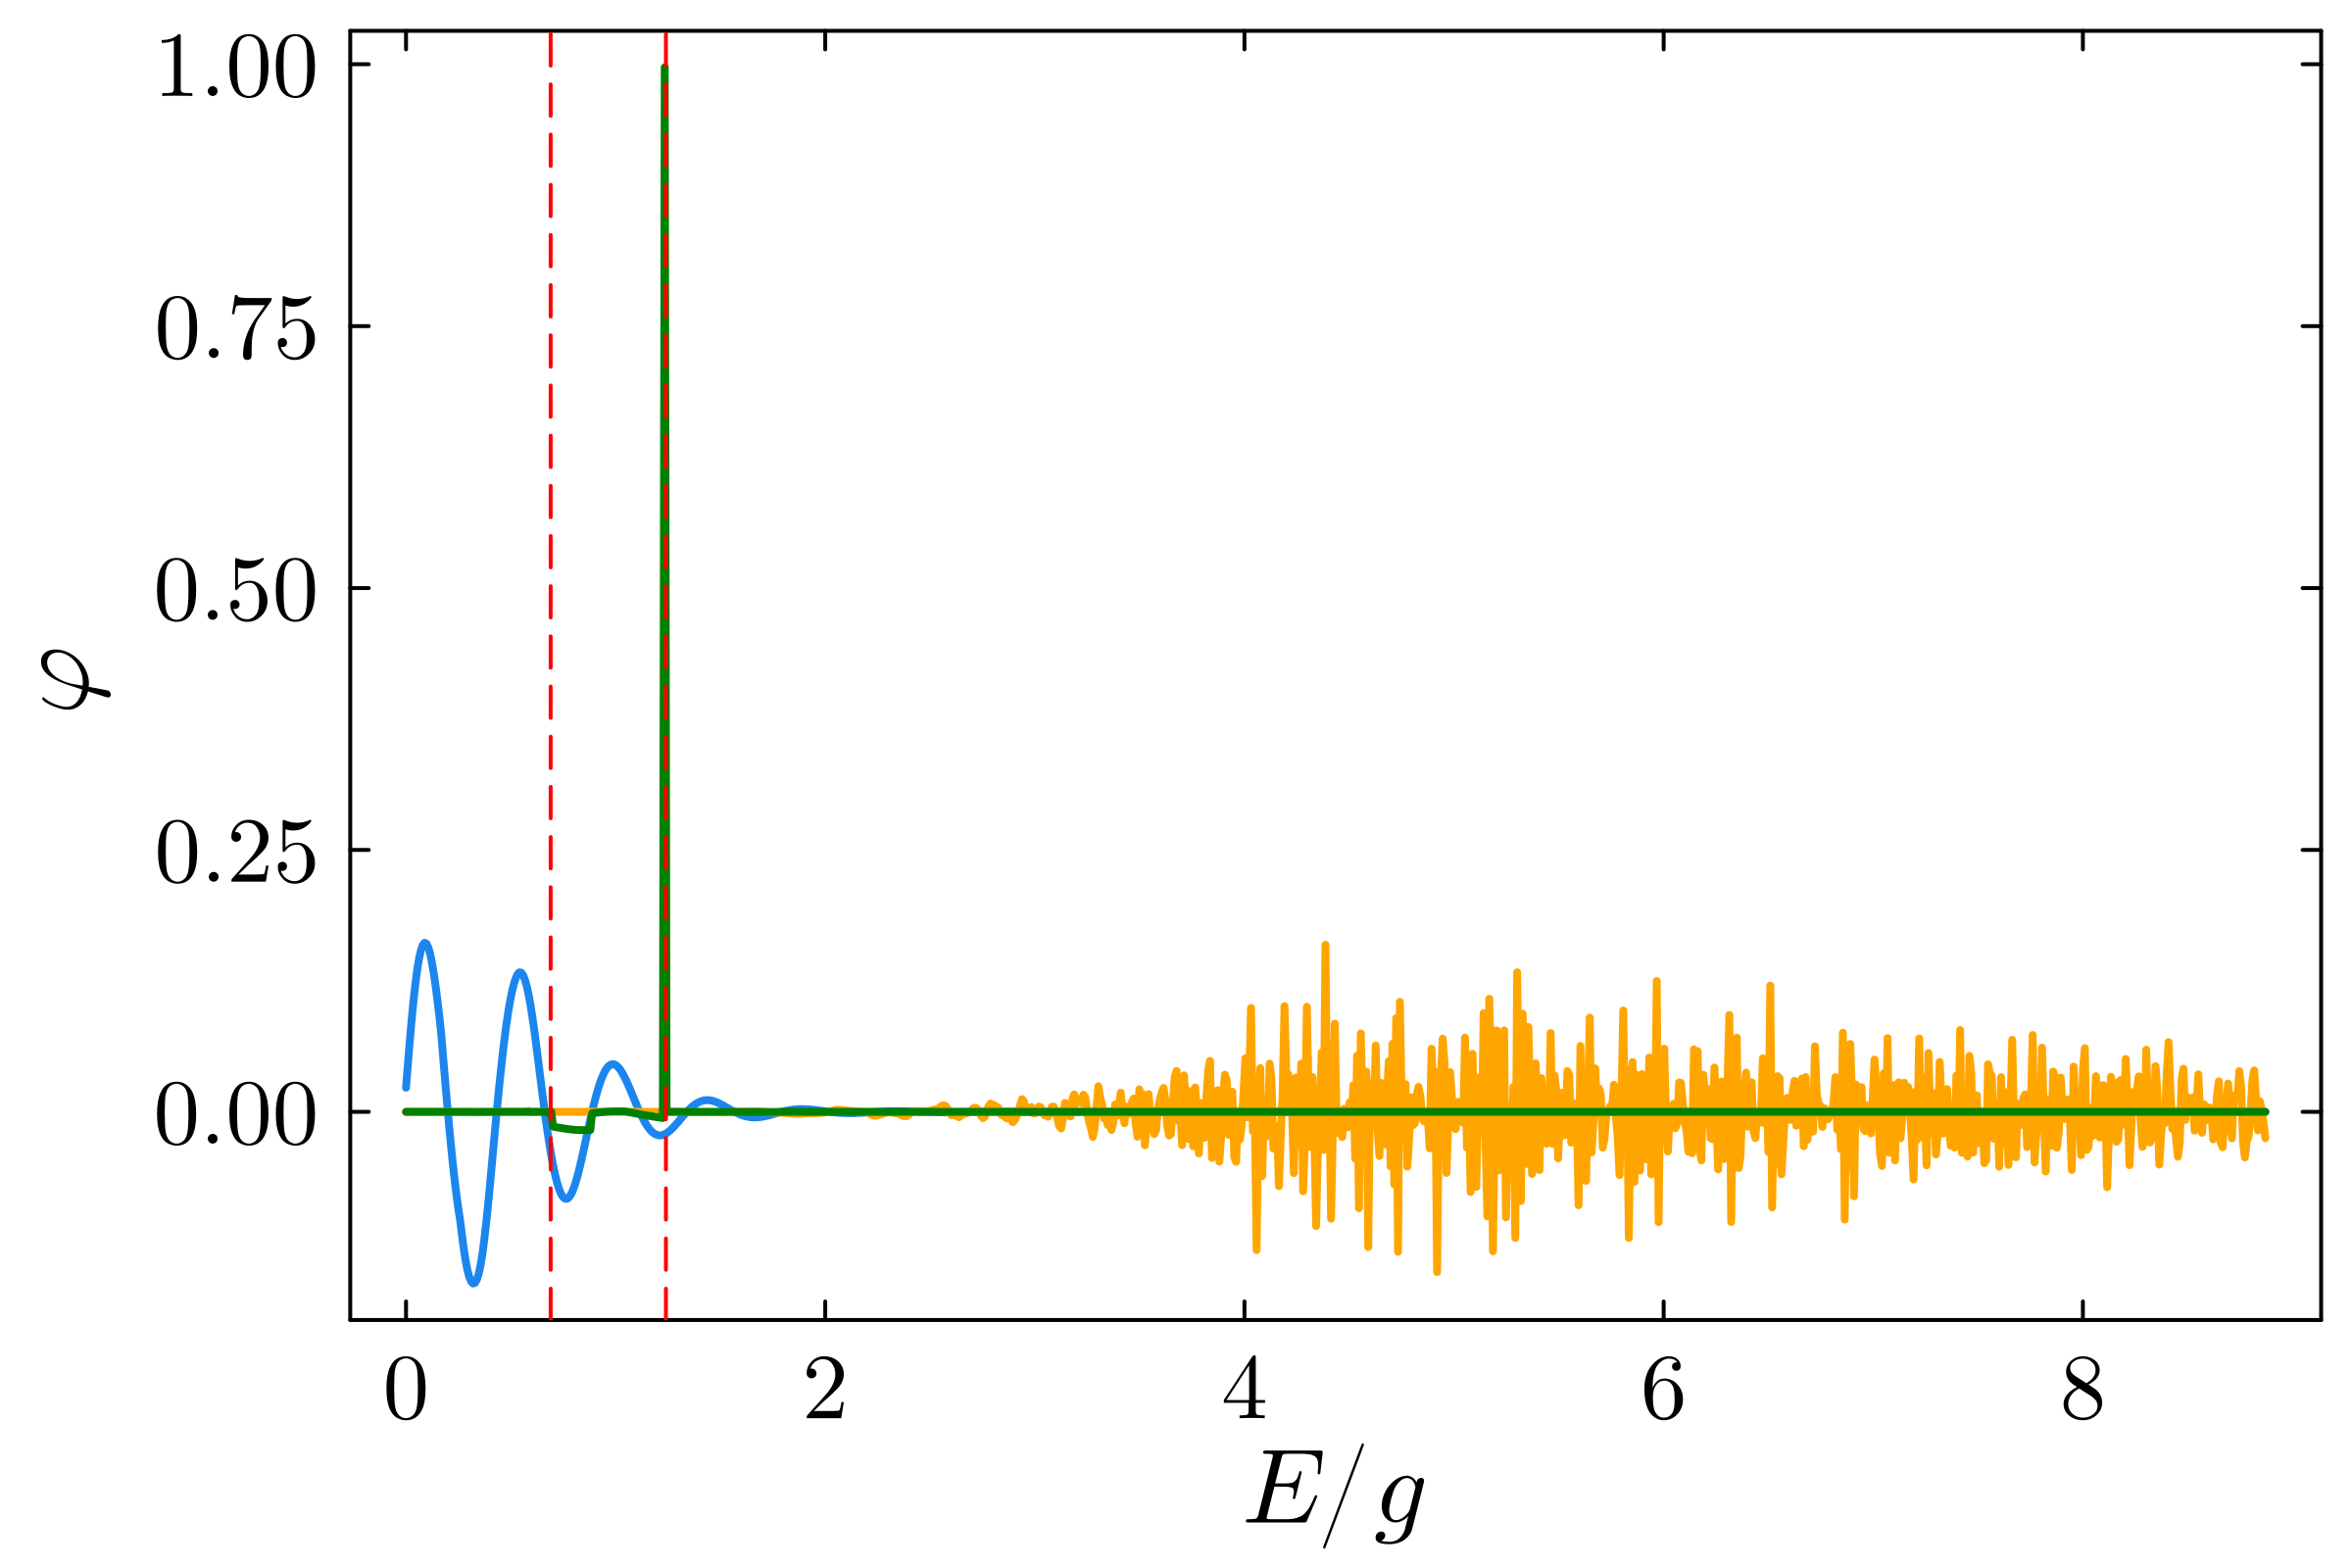

In [27]:
### Plot the corresponding eigenvector ###

N1_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[1] );  # Absolute value smallest. Most delocalized. 
N2_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[31] );
N3_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[62] ); # Absolute value is largest. Most localized.

N1_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[938] ); # Absolute value is smallest. Most delocalized.
N2_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[469] );
N3_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[1] );   # Absolute value is largest. Most localized. 

E_Range = range(start=0, step=(ΔE/g), length=L);

######################################################################################################################    
                                            ### Stable Eigenvectors ###
######################################################################################################################

plot( E_Range, F.vectors[:,(N1_S_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:dodgerblue2,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N2_S_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:orange,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N3_S_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:green,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

######################################################################################################################    
######################################################################################################################
######################################################################################################################

E_Z_0_min1 = 0.69; 
plot!([E_Z_0_min1], seriestype="vline", dpi = 400,
    lw=1, linestyle=:dash, linecolor=:red)

E_Z_0_min2 = 1.24; 
plot!([E_Z_0_min2], seriestype="vline", dpi = 400,
        lw=1, linestyle=:dash, linecolor=:red)

xlabel!( L"E/g")
ylabel!( L"\varphi" )

### **Unstable eigenvectors**

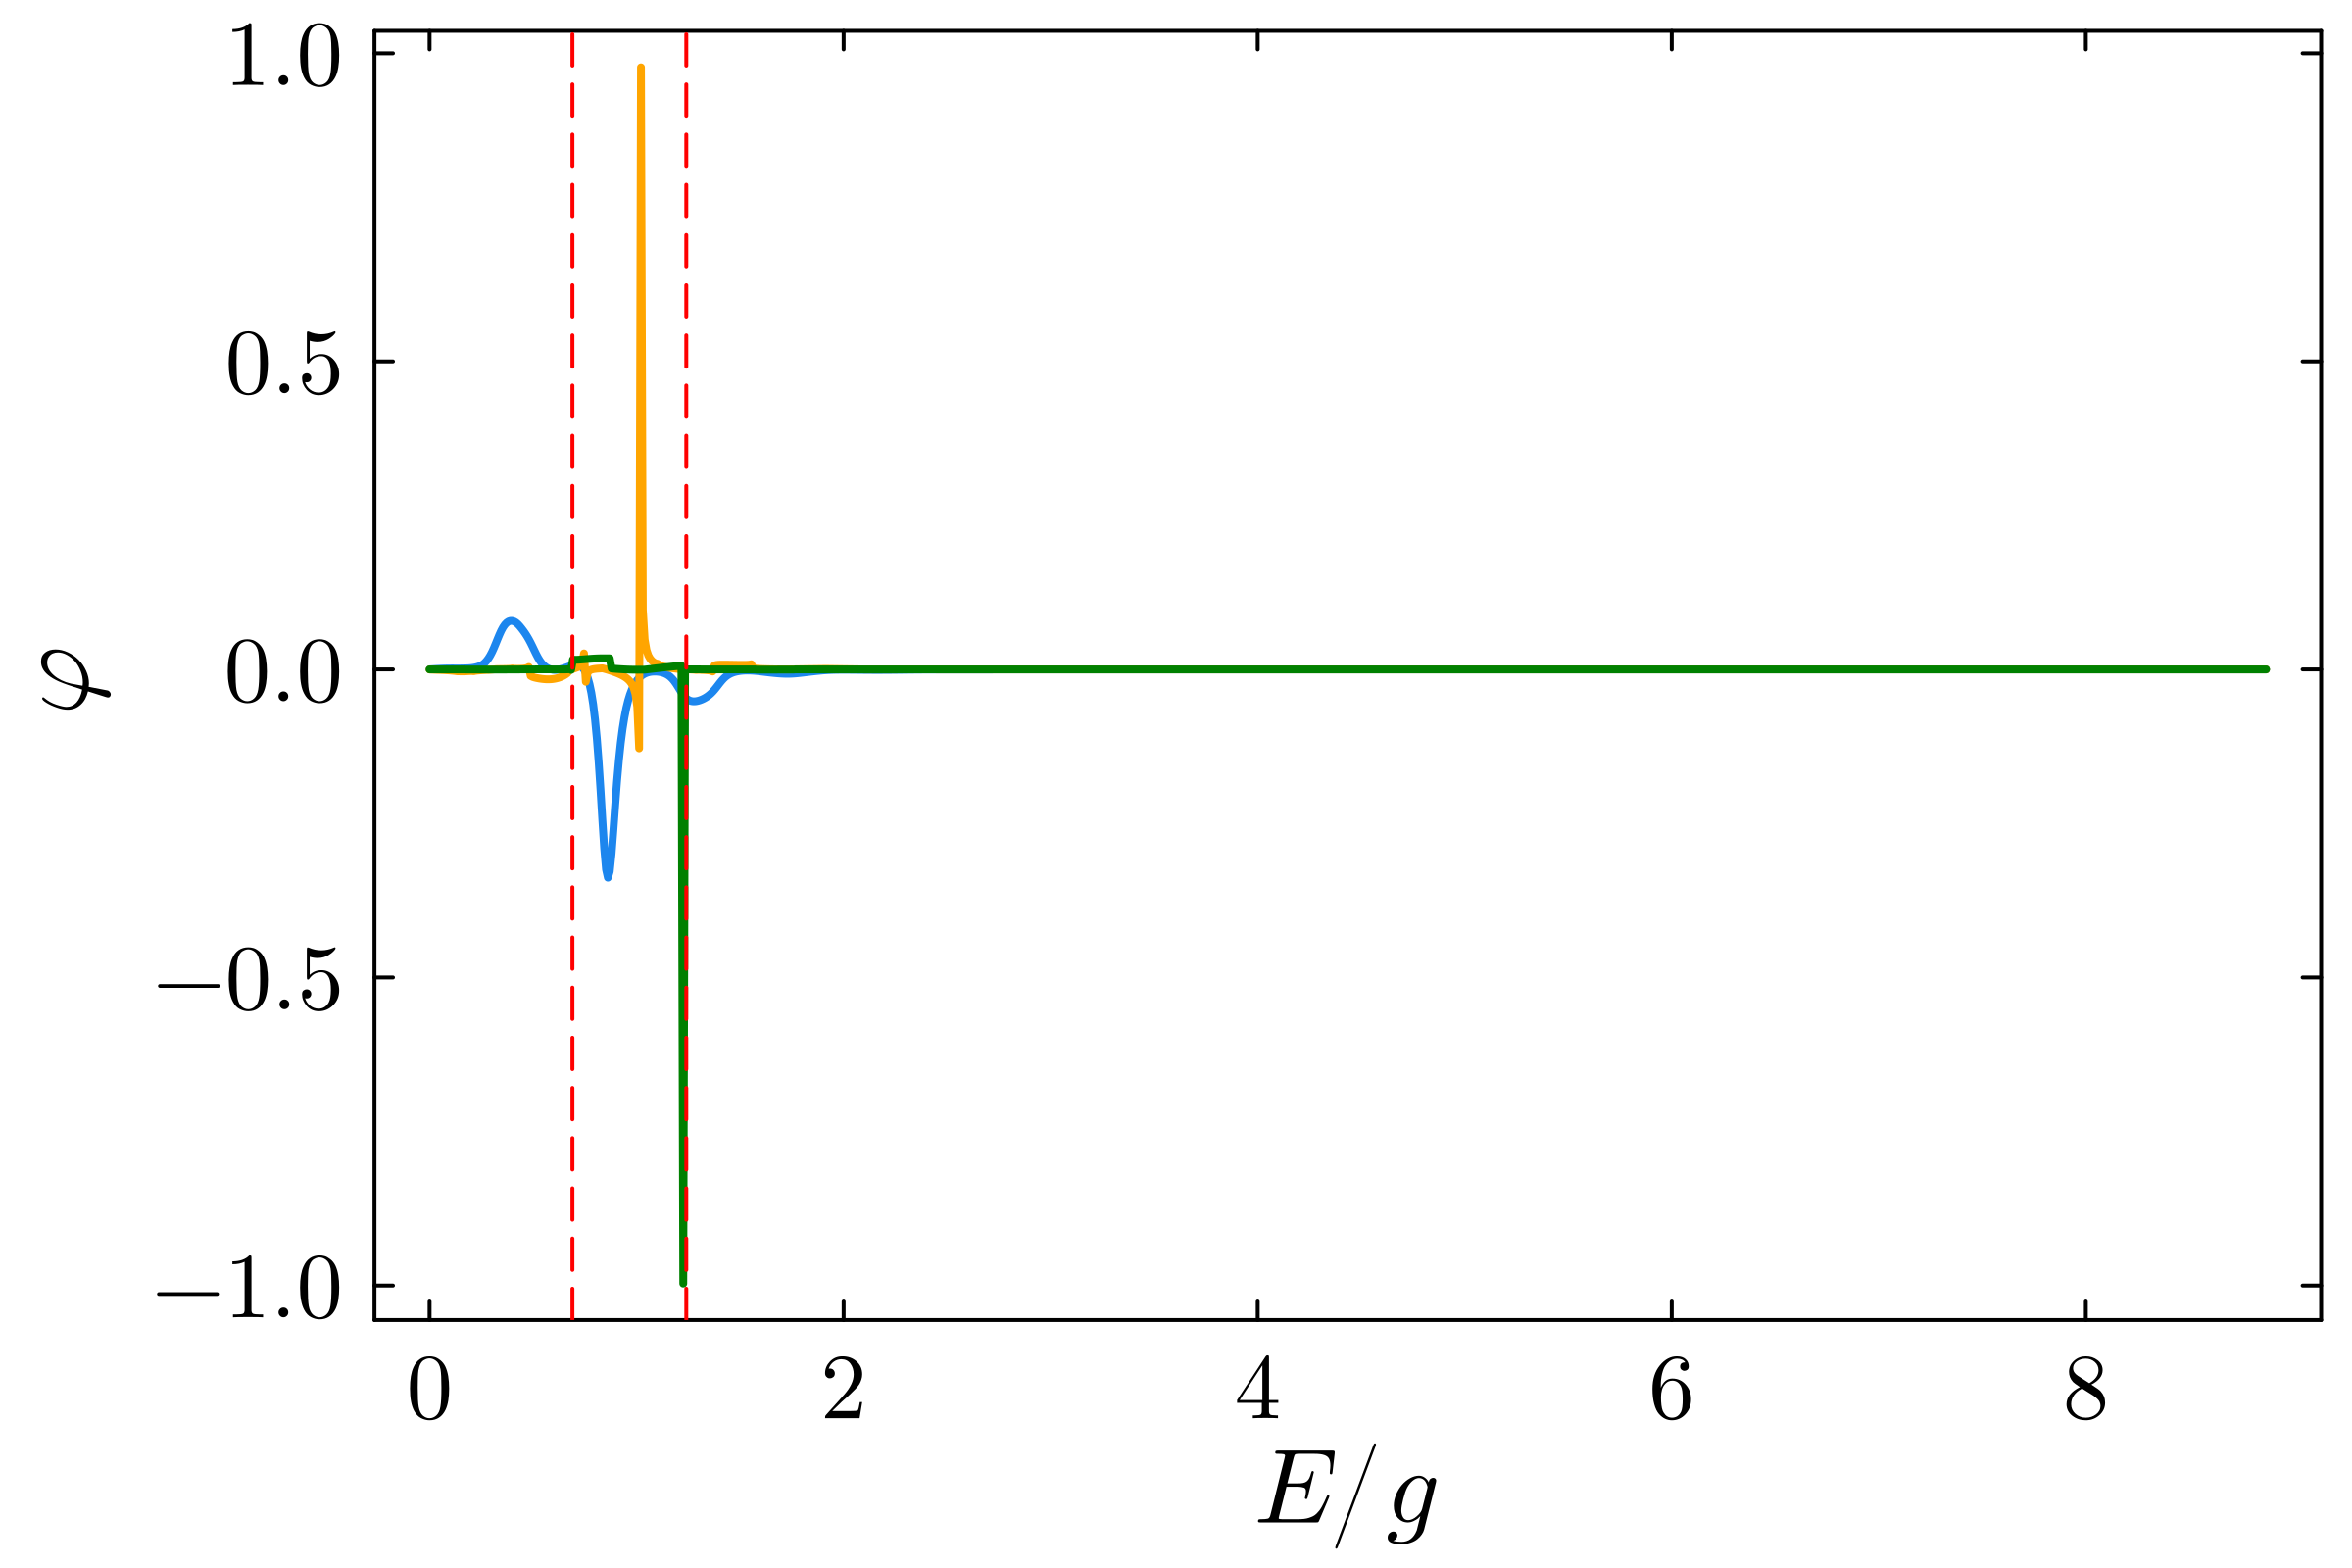

In [28]:
### Plot the corresponding eigenvector ###

N1_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[1] );  # Absolute value smallest. Most delocalized. 
N2_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[31] );
N3_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[62] ); # Absolute value is largest. Most localized.

N1_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[938] ); # Absolute value is smallest. Most delocalized.
N2_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[469] );
N3_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[1] );   # Absolute value is largest. Most localized. 

E_Range = range(start=0, step=(ΔE/g), length=L);

######################################################################################################################    
                                            ### Unstable Eigenvectors ###
######################################################################################################################

plot( E_Range, F.vectors[:,(N1_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:dodgerblue2,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N2_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:orange,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N3_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:green,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

######################################################################################################################    
######################################################################################################################
######################################################################################################################

E_Z_0_min1 = 0.69; 
plot!([E_Z_0_min1], seriestype="vline", dpi = 400,
    lw=1, linestyle=:dash, linecolor=:red)

E_Z_0_min2 = 1.24; 
plot!([E_Z_0_min2], seriestype="vline", dpi = 400,
        lw=1, linestyle=:dash, linecolor=:red)

xlabel!( L"E/g")
ylabel!( L"\varphi" )

# **Code to obtain $\lambda_\textrm{critical}$ for different values of $T_0/g$**

## **List of temperatures and corresponding $\lambda_\textrm{critical}$**

In [29]:
N_τ0    = 10;

τ0_Range = (0.18:(0.29-0.18)/(N_τ0-1):0.29);            # τ = T0/g

τ0_Range = round.( τ0_Range; digits=3 )

10-element Vector{Float64}:
 0.18
 0.192
 0.204
 0.217
 0.229
 0.241
 0.253
 0.266
 0.278
 0.29

## **Linear Analysis: Temperature Dependence**

In [30]:
######################################################################################################################
                                        ### Initialize the lists ### 
######################################################################################################################

N_τ0                  = 10;

τ0_List               = (0.18:(0.29-0.18)/(N_τ0-1):0.29); # τ = T0/g

τ0_List               = round.( τ0_List; digits=3 );

λ_Critical_List       = zeros( length(τ0_List) );

λ_Critical_Guess_List = [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 8.0, 21.0]; # Obtained from scanning Z_0(E)
λ_Critical_Guess_List = λ_Critical_Guess_List .- 0.1; 

######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### START WHILE LOOP ### 
                        ### Runs until we achieve the desired accuracy in λ_Critical or if λ > λ_Max ###
######################################################################################################################

tick()

for tt = 1 : N_τ0



    ######################################################################################################################
                        ### Define the Parameters. We choose to do it for different L manually. ### 
    ######################################################################################################################
    
    L                           = 1000;                           # Related to the cut-off of the energy 

    r_Left                      = 40;                             # Minimum Phonon frequency
    r_Right                     = 60;                             # Maximum Phonon frequency  
    N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
    r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                                  # Multiple frequencies

    ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
    Ω_List                      = ΔE .* r_List;                   # Ω_List

    λ                           = λ_Critical_Guess_List[tt];      # Initialize the electron-phonon intereaction
                                                                  # Make this smaller than the smallest possible λ_Critical 
                                                                  # for all the T0 considered.
    λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
 
    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
                                                    ### Scanning over λ ### 
    ######################################################################################################################

    Δλ                   = 1e-1;       # Choose an initial Ω step

    ελ_Critical          = 1e-5;       # Choose an error-bar for Ω_Critical

    λ_Max                = 1e2;        # This is the maximum value of the electron-phonon interaction that we consider 

    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################



    while Δλ > (ελ_Critical) && λ < λ_Max
    


        ######################################################################################################################
                                                ### Defining the temperature. It depends on λ. ###
                                            ### This needs to be updated every time we update λ. ### 
                                                    ### All the matrices depend on T0. ###  
        ######################################################################################################################
    
        g  = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );        # g is now changed
    
        T0 = τ0_List[tt] * g;                                # This should be higher than T_Critical for the kinetic equation to be valid
    
        ######################################################################################################################    
        ######################################################################################################################
        ######################################################################################################################
        
        
        
        ##################################################################################################################################################################
        ### DEFINING ALL THE MATRICES ###
        ##################################################################################################################################################################
    
        A_Total_Mat = zeros( L, L ); 
        Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );
    
    
        ######################################################################################################################
        ### Define the total B ###
        ######################################################################################################################
    
        B_Total_Mat = zeros( L, L );
    
        # for i = 1:N_Phonon 
    
        #     B_Int_Mat   = zeros( L, L ); 
        #     Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
        #     B_Total_Mat = B_Total_Mat + B_Int_Mat;
    
        # end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total C ###
        ######################################################################################################################
    
        C_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            C_Int_Mat   = zeros( L, L ); 
            Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            C_Total_Mat = C_Total_Mat + C_Int_Mat;
    
        end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total P ###
        ######################################################################################################################
    
        P_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            P_Int_Mat   = zeros( L, L ); 
            Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            P_Total_Mat = P_Total_Mat + P_Int_Mat;
    
        end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total Q ###
        ######################################################################################################################
    
        Q_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            Q_Int_Mat   = zeros( L, L ); 
            Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;
    
        end
    
        Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 
    
    
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
    
    
    
            
        ##################################################################################################################################################################
        ### Generalized eigenvalue problem: Ax = λBx. 
        ### To find λ: eigen(A, B)   
        ### The form of our problem: (C-D)φ = λ(A-B)φ
        ### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
        ### We now do the generaized diagonalization by hand.
        ### Note that: We write C-D = L.L^{T} = R^{T}.R
        ##################################################################################################################################################################
    
        RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
        R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;
    
        Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );
    
        F                  = eigen( Symm_LHS );
    
        Eigs_Real          = sort( 1.0 ./ real( F.values ) );
        Eigs_Max           = maximum( real( Eigs_Real ) ); # Obtaining the eigenvalue. We use the LinearAlgebra package.
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
    
        
                
        ##################################################################################################################################################################
        ### UPDATING THE ELECTRON-PHONON INTERACTION STRENGTH ###
        ##################################################################################################################################################################
        
        if Eigs_Max > ελ_Critical
            
            λ_Critical_List[tt] = λ;                              # Saving λ
            
            λ                  -= Δλ;                             # After hitting the singularity, New λ = (λ_Critical at this step) - Δλ

            λ_List              = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
        
            Δλ                 /= 10;                             # After hitting the singularity, Δλ_New = Δλ_Old/10
        
        else
            
            # println("Calculation for λ = $( round( sum(λ_List); digits=5) ) done!");
        
            λ      += Δλ;                                         # If no singularity, λ_New = λ_Old + Δλ 

            λ_List  = (λ/N_Phonon) .* ones(N_Phonon);             # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ)
            
        end
        
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        
    end

    ######################################################################################################################
                                                    ### END WHILE LOOP ### 
                                ### Runs until we achieve the desired accuracy in Ω_Critical ###
    ######################################################################################################################
    
    println("λ_Critical for T₀/g = $( τ0_List[tt] ) with L = $( L ), r_Left = $( r_Left ), and r_Right = $( r_Right ) is $( round(λ_Critical_List[tt];digits=5) ).");

end

tock()

######################################################################################################################
                                                ### END WHILE LOOP ### 
                            ### Runs until we achieve the desired accuracy in Ω_Critical ###
######################################################################################################################

┌ Info:  started timer at: 2025-07-08T20:04:26.049
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


λ_Critical for T₀/g = 0.18 with L = 1000, r_Left = 40, and r_Right = 60 is 1.1335.
λ_Critical for T₀/g = 0.192 with L = 1000, r_Left = 40, and r_Right = 60 is 1.3262.
λ_Critical for T₀/g = 0.204 with L = 1000, r_Left = 40, and r_Right = 60 is 1.5644.
λ_Critical for T₀/g = 0.217 with L = 1000, r_Left = 40, and r_Right = 60 is 1.8991.
λ_Critical for T₀/g = 0.229 with L = 1000, r_Left = 40, and r_Right = 60 is 2.3097.
λ_Critical for T₀/g = 0.241 with L = 1000, r_Left = 40, and r_Right = 60 is 2.8822.
λ_Critical for T₀/g = 0.253 with L = 1000, r_Left = 40, and r_Right = 60 is 3.7428.
λ_Critical for T₀/g = 0.266 with L = 1000, r_Left = 40, and r_Right = 60 is 5.3642.
λ_Critical for T₀/g = 0.278 with L = 1000, r_Left = 40, and r_Right = 60 is 8.6521.
λ_Critical for T₀/g = 0.29 with L = 1000, r_Left = 40, and r_Right = 60 is 21.1356.


┌ Info:         82.518718334s: 1 minute, 22 seconds, 518 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


In [31]:
@save "Data_Fig_2_Supp_Material/λ_Critical_List_LS.jld2" τ0_Range λ_Critical_List;

## **Plotting $\lambda_{c}(T_{0})$ vs $T_0/g$**

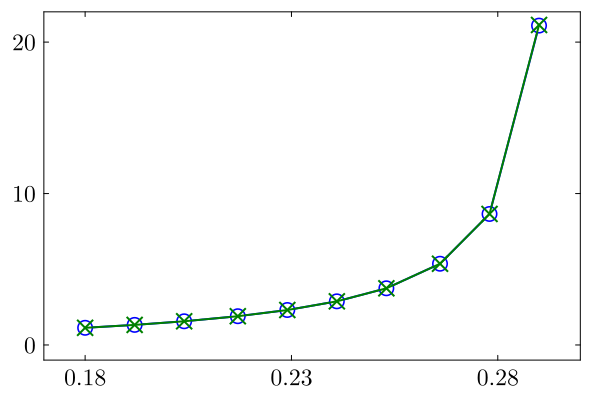

In [3]:
N_τ0    = 10;

τ0_Range = (0.18:(0.29-0.18)/(N_τ0-1):0.29);            # τ = T0/g

τ0_Range = round.( τ0_Range; digits=3 )

### I obtained these by the linear analysis above ###
λ_Critical_List_LS = [1.1335, 1.3262, 1.5644, 1.8991, 2.3096, 2.8822, 3.7427, 5.3639, 8.6508, 21.0891];

### I obtained these by calculating $Z_{0}^{-1}(E)$ using a Mathematica program ###
λ_Critical_List_Z0 = [1.1333, 1.3253, 1.5644, 1.8980, 2.3094, 2.8820, 3.7416, 5.3642, 8.6517, 21.1315];

plot( τ0_Range, λ_Critical_List_LS,  
    shape=:circle, ms=8, mc=:white, msc=:blue, msw=2, lw=2, linestyle=:solid, linecolor=:blue,
    tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, legend=false,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

plot!( τ0_Range, λ_Critical_List_Z0,  
    shape=:xcross, ms=8, mc=:green, msc=:green, msw=2, lw=2, linestyle=:solid, linecolor=:green,
    tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, legend=false,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

xlims!( 0.17, 0.30 )
ylims!( -1, 22 )

Xt = collect(range(0.18, 0.30,step=0.05));
Yt = collect(range(0,    50,  step=10));

xticks!(Xt, string.( round.( Xt, digits=2 ) ))
yticks!(Yt, string.( Int.( Yt ) ))